In [1]:
from collections import defaultdict
from functools import total_ordering
from math import erf
from statistics import NormalDist

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib notebook

In [2]:
years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/years.csv")
team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_years.csv")
events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/events.csv")
matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/matches.csv")
team_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_matches.csv")

In [3]:
SQRT2 = 2 ** 0.5

@total_ordering
class Normal:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    @staticmethod
    def add(n1, n2, corr):
        new_mu = n1.mu + n2.mu
        new_sigma = (n1.sigma ** 2 + n2.sigma ** 2 + 2 * corr * n1.sigma * n2.sigma) ** 0.5
        return Normal(new_mu, new_sigma)
    
    @staticmethod
    def sub(n1, n2, corr):
        new_mu = n1.mu - n2.mu
        new_sigma = (n1.sigma ** 2 + n2.sigma ** 2 - 2 * corr * n1.sigma * n2.sigma) ** 0.5
        return Normal(new_mu, new_sigma)
    
    def __rmul__(self, other):
        return Normal(other * self.mu, other * self.sigma)
    
    def __lt__(self, other):
        return self.mu < other.mu
    
    def win_prob(self):
        return 0.5 - 0.5 * erf(-self.mu / (self.sigma * SQRT2))
    
    def __repr__(self):
        return "Normal (" + str(round(self.mu, 4)) + ", " + str(round(self.sigma, 4)) + ")"

In [218]:
class History:
    def __init__(self):
        self._history = []
        
    def history(self, name):
        return [x[name] for x in self._history]
    
    def mean(self):
        raise NotImplementedError
    
    def sd(self):
        raise NotImplementedError
        
    def record(self, obs):
        self._history.append({
            "x": len(self._history),
            "obs": obs,
            "mean": self.mean(),
            "sd": self.sd(),
        })
        
    @staticmethod
    def plot_history(objs):
        fig, ax = plt.subplots(figsize=(9, 6))
        colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
        for color, obj in zip(colors, objs):
            x = obj.history("x")
            scaled_x = [x_i / (len(x) - 1) for x_i in x]
            ax.scatter(scaled_x, obj.history("obs"), label="Observations")
            ax.plot(scaled_x, obj.history("mean"), label="Mean")
            ax.fill_between(
                scaled_x, 
                [x - 2 * y for x, y in zip(obj.history("mean"), obj.history("sd"))], 
                [x + 2 * y for x, y in zip(obj.history("mean"), obj.history("sd"))],
                color=color, 
                alpha=0.4, 
                label="CI"
            )
            
        ax.legend()
        ax.grid()
        fig.show()

    def end_mean(self):
        data = self.history("mean")[-5:]
        return sum(data) / max(1, len(data))
    
    def max_mean(self):
        return max(self.history("mean"))

In [483]:
class Rating(History):
    def __init__(self, prior_mean, sd_func):
        super().__init__()
        
        self.n = 0
        self.mu = 0 if prior_mean < 5 else prior_mean
        self.sd_func = sd_func
        
    def add(self, x, percent, weight):
        self.record(x)
        mean = self.mu
        new_mu = self.mu * (1 - percent) + x * percent
        self.mu = (1 - weight) * self.mu + weight * new_mu
        self.n += 1 if weight == 1 else 0
        
    def mean(self):
        return self.mu
    
    def sd(self):
        return self.sd_func(self.mean())
    
    def __repr__(self):
        return "Rating (" + str(round(self.mean(), 2)) + ", " + str(round(self.sd(), 2)) + ")"

In [484]:
class Prediction:
    def __init__(self, win_prob, red_pred, red_sd, blue_pred, blue_sd):
        self.win_prob = win_prob
        self.red_pred = red_pred
        self.red_sd = red_sd
        self.blue_pred = blue_pred
        self.blue_sd = blue_sd
        

class ModelStats:
    def __init__(self):
        self.win_prob = []
        self.score_pred = []
        
    def record_stats(self, match, pred):
        win_prob = pred.win_prob
        acc = {0: "blue", 1: "red"}[win_prob > 0.5] == match.winner
        mse = (1 - win_prob) ** 2 if match.red_score > match.blue_score else win_prob ** 2
        self.win_prob.append({
            "event": match.event,
            "playoff": match.playoff,
            "key": match.key,
            "winner": match.winner,
            "win_prob": win_prob,
            "conf": max(win_prob, 1 - win_prob),
            "acc": acc,
            "mse": mse,
        })
        
        for alliance, score, score_pred, pred_sd, in [
            ("red", match.red_no_fouls, pred.red_pred, pred.red_sd),
            ("blue", match.blue_no_fouls, pred.blue_pred, pred.blue_sd),
        ]:
            self.score_pred.append({
                "event": match.event,
                "playoff": match.playoff,
                "key": match.key,
                "alliance": alliance,
                "score": score,
                "score_pred": score_pred,
                "mse": (score - score_pred) ** 2,
                "sd": pred_sd,
            })
        
    def print_stats(self):
        win_prob_df = pd.DataFrame(self.win_prob)
        score_pred_df = pd.DataFrame(self.score_pred)
        
        def agg_win_prob(name, _filter):
            temp_df = _filter(win_prob_df)
            temp = temp_df.agg({"event": "count", "conf": "mean", "acc": "mean", "mse": "mean"})
            print(name, "\t\t" + str(int(temp.event)) + "\t" + f"{temp.conf:.4f}" + "\t" + f"{temp.acc:.4f}" + "\t" + f"{temp.mse:.4f}")
        
        def agg_score_pred(name, _filter):
            temp_df = _filter(score_pred_df)
            temp = temp_df.agg({"event": "count", "mse": "mean", "sd": "mean"})
            print(name, "\t\t" + str(int(temp.event)) + "\t" + f"{temp.mse:.2f}" + "\t" + f"{temp.sd:.3f}")
        
        worlds_events = ["2022carv", "2022gal", "2022hop", "2022new", "2022roe", "2022tur"]
        
        print("Win Prob")
        print("Category\tCount\tConf\tAcc\tMSE")
        agg_win_prob("Quals", lambda x: x[x.playoff == False])
        agg_win_prob("Elims", lambda x: x[x.playoff == True])
        agg_win_prob("Champs", lambda x: x[(x.event.isin(worlds_events)) & (x.playoff == False)])
        print()
        
        print("Score Pred")
        print("Category\tCount\tMSE\tSD")
        agg_score_pred("Quals", lambda x: x[x.playoff == False])
        agg_score_pred("Elims", lambda x: x[x.playoff == True])
        agg_score_pred("Champs", lambda x: x[(x.event.isin(worlds_events)) & (x.playoff == False)])
        print()
        
    def plot_calibration(self):
        win_prob_df = pd.DataFrame(self.win_prob)
        score_pred_df = pd.DataFrame(self.score_pred)
        
        fig, axs = plt.subplots(3, 2, figsize=(9, 10))
        
        # FIGURE 1
        x, y, n = [], [], 40
        for i in range(n):
            percent = i / n
            subset_df = win_prob_df[(win_prob_df.win_prob > percent) & (win_prob_df.win_prob < percent + 1 / n)]
            actual_percent = subset_df[subset_df.winner == "red"].shape[0] / subset_df.shape[0]
            x, y = x + [percent + 1 / (2 * n)], y + [actual_percent]
        x, y = np.array(x), np.array(y)
        axs[0, 0].scatter(x, y)
        axs[0, 0].plot(x, x, color="tab:green")
        axs[0, 0].set_title("Win Probability Calibration")
        axs[0, 0].set_xlabel("Predicted %")
        axs[0, 0].set_ylabel("Actual %")
        
        # FIGURE 2
        x, y = [], []
        for i in range(175):
            subset_df = score_pred_df[(score_pred_df.score_pred > i) & (score_pred_df.score_pred < i + 1)]
            actual = subset_df.score.mean()
            x, y = x + [i], y + [actual]
        x, y = np.array(x), np.array(y)
        axs[0, 1].scatter(x, y)
        m, b = np.polyfit(score_pred_df.score_pred, score_pred_df.score, 1)
        axs[0, 1].text(75, 25, str(round(m, 4)) + "x + " + str(round(b, 1)))
        axs[0, 1].plot([x for x in range(175)], [x for x in range(175)], color="tab:green")
        axs[0, 1].plot([x for x in range(175)], [m * x + b for x in range(175)], color="tab:orange")
        axs[0, 1].set_title("Score Prediction Calibration")
        axs[0, 1].set_xlabel("Predicted Score")
        axs[0, 1].set_ylabel("Actual Score")
        
        
        # FIGURE 3
        xs, ys = [], []
        for i in range(10, 50):
            distrib = []
            for team in self.ratings.values():
                for obs, mean in zip(team.history("obs"), team.history("mean")):
                    if mean > i and mean < i + 1:
                        distrib.append(obs)
            if len(distrib) > 0:
                norm = NormalDist.from_samples(distrib)
                xs, ys = xs + [i], ys + [norm.stdev]
        xs, ys = np.array(xs), np.array(ys)
        axs[1, 0].scatter(xs, ys)
        a, b = np.polyfit(xs, ys, 1)
        axs[1, 0].plot(xs, a * xs + b)
        axs[1, 0].text(25, 5, str(round(a, 4)) + "x + " + str(round(b, 1)))
        axs[1, 0].set_title("Standard Deviation Tuning")
        axs[1, 0].set_xlabel("Mean Score")
        axs[1, 0].set_ylabel("Observed SD")
        
        # FIGURE 4
        distrib = []
        for team in self.ratings.values():
            for obs, mean, sd in zip(team.history("obs"), team.history("mean"), team.history("sd")):
                distrib.append((obs - mean) / sd)
        axs[1, 1].hist(distrib, bins=100, density=True, range=(-4, 4))
        norm = NormalDist.from_samples(distrib)
        axs[1, 1].text(2, 0.3, "sd=" + str(round(norm.stdev, 4)))
        x = np.linspace(-4, 4, 1000)
        y = 1 / np.sqrt(2 * np.pi) / norm.stdev * np.exp(-1 / 2 * ((x - norm.mean) / norm.stdev) ** 2)
        axs[1, 1].plot(x, y)
        axs[1, 1].set_title("Standard Deviation Calibration")
        axs[1, 1].set_xlabel("Standard Deviation")
        axs[1, 1].set_ylabel("Frequency")
        
        elos, oprs = {}, {}
        for _, t in team_years_df[(team_years_df.year == 2022)].iterrows():
            elos[t.team] = t.elo_end
            oprs[t.team] = t.opr
            
        x, y, y2 = [], [], []
        for team in self.ratings:
            if self.ratings[team].end_mean() == 0:
                continue
            x.append(elos[team])
            y.append(self.ratings[team].end_mean())
            y2.append(oprs[team])
        x, y, y2 = np.array(x), np.array(y), np.array(y2)
            
        # FIGURE 5
        axs[2, 0].scatter(x, y, s=1, label="Rating")
        m1, b1 = np.polyfit(x, y, 1)
        axs[2, 0].plot(x, m1 * x + b1)
        axs[2, 0].text(1800, 20, str(round(m1, 4)) + "x + " + str(int(b1)), c="tab:blue")
        axs[2, 0].scatter(x, y2, s=1, label="OPR")
        m2, b2 = np.polyfit(x, y2, 1)
        axs[2, 0].plot(x, m2 * x + b2)
        axs[2, 0].text(1400, 60, str(round(m2, 4)) + "x + " + str(int(b2)), c="tab:orange")
        axs[2, 0].legend()
        axs[2, 0].set_title("Rating/OPR vs Elo")
        axs[2, 0].set_xlabel("Elo Rating")
        axs[2, 0].set_ylabel("Rating/OPR")
        
        # FIGURE 6
        rating_buckets, opr_buckets = [], []
        for i in range(80):
            temp = [o for r, o in zip(list(y), list(y2)) if r > i and r < i + 1]
            if len(temp) == 0:
                continue
            rating_buckets.append(i + 1 / 2)
            opr_buckets.append(sum(temp) / len(temp))
        axs[2, 1].scatter(rating_buckets, opr_buckets)
        # axs[1, 1].scatter(y, y2, s=1)
        m3, b3 = np.polyfit(y, y2, 1)
        axs[2, 1].plot(y, m3 * y + b3)
        axs[2, 1].text(40, 20, str(round(m3, 4)) + "x + " + str(round(b3, 2)))
        axs[2, 1].plot(y, y, c="tab:green")
        axs[2, 1].set_title("OPR vs Rating")
        axs[2, 1].set_xlabel("Rating")
        axs[2, 1].set_ylabel("OPR")
        
        fig.tight_layout()
        fig.show()
        
    def summary(self, teams=[]):
        best_teams = sorted(self.ratings.items(), key=lambda x: -x[1].end_mean())[:10]
        for team, rating in best_teams:
            print(team, "\t", round(rating.end_mean(), 2), round(rating.max_mean(), 2))
        print()
        
        if len(teams) > 0:
            History.plot_history([self.ratings[t] for t in teams])

In [540]:
class Model(ModelStats):
    def __init__(self, init_ratings, sum_func, percent_func, margin_func, sd_func):
        super().__init__()
        
        self.sum_func = sum_func
        self.margin_func = margin_func
        self.percent_func = percent_func
        
        def rating_prior_mean(mean):
            return Rating(prior_mean=mean, sd_func=sd_func)
        
        if init_ratings is not None:
            self.ratings = init_ratings
        else:
            self.ratings = defaultdict(lambda: rating_prior_mean(13.8))
            for _, t in team_years_df[(team_years_df.year == 2022)].iterrows():
                team, opr = t.team, 13.8 + (t.elo_start - 1500) / 250 * 22
                self.ratings[team] = rating_prior_mean(opr)
                
            
    def eval_match(self, match):
        red_teams = [int(x) for x in match.red.split(",")]
        blue_teams = [int(x) for x in match.blue.split(",")]

        red_means, red_sds = [self.ratings[t].mean() for t in red_teams], [self.ratings[t].sd() for t in red_teams]
        red_mean, red_sd = self.sum_func(red_means), self.sum_func(red_sds)
        
        blue_means, blue_sds = [self.ratings[t].mean() for t in blue_teams], [self.ratings[t].sd() for t in blue_teams]
        blue_mean, blue_sd = self.sum_func(blue_means), self.sum_func(blue_sds)
        
        red_distrib, blue_distrib = Normal(red_mean, red_sd), Normal(blue_mean, blue_sd)
        win_prob = Normal.sub(red_distrib, blue_distrib, 0).win_prob()
        
        # win_prob = (win_prob + match.elo_win_prob) / 2
        pred = Prediction(win_prob=win_prob, red_pred=red_mean, red_sd=red_sd, blue_pred=blue_mean, blue_sd=blue_sd)
        self.record_stats(match, pred)
        
        red_score, blue_score = match.red_no_fouls, match.blue_no_fouls
        for team, mean in zip(red_teams, red_means):
            margin_factor = self.margin_func(self.ratings[team].n)
            percent = self.percent_func(self.ratings[team].n)
            error = ((red_score - red_mean) + margin_factor * (blue_mean - blue_score)) / (1 + margin_factor)
            self.ratings[team].add(mean + 1 / 3 * error, percent, 1/4 if match.playoff else 1)
            
        for team, mean in zip(blue_teams, blue_means):
            margin_factor = self.margin_func(self.ratings[team].n)
            percent = self.percent_func(self.ratings[team].n)
            error = ((blue_score - blue_mean) + margin_factor * (red_mean - red_score)) / (1 + margin_factor)
            self.ratings[team].add(mean + 1 / 3 * error, percent, 1/4 if match.playoff else 1)
                
    def eval_matches(self):
        event_matches_df = matches_df[(matches_df.year == 2022) & (matches_df.status == "Completed")].sort_values(by=["time"])
        for _, match in event_matches_df.iterrows():
            self.eval_match(match)
        

In [537]:
def elo_sd_func(x):
    return 6.08

def elo_margin_func(x):
    return 1

def elo_percent_func(x):
    return 72/250

def sum_func(arr):
    return sum(arr)

elo_model = Model(init_ratings=None, sum_func=sum_func, percent_func=elo_percent_func, margin_func=elo_margin_func, sd_func=elo_sd_func)  # ELO MODEL
elo_model.eval_matches()
elo_model.print_stats()

Win Prob
Category	Count	Conf	Acc	MSE
Quals 		12048	0.7083	0.7513	0.1648
Elims 		2581	0.7308	0.7869	0.1498
Champs 		756	0.7826	0.7804	0.1466

Score Pred
Category	Count	MSE	SD
Quals 		24096	345.99	18.240
Elims 		5162	294.15	18.240
Champs 		1512	469.07	18.240



In [543]:
def sd_func(x):
    return 4.5 # 0.0125 * x + 4.3

def margin_func(x):
    return min(1, max(0, 1 / 24 * (x - 12)))

def percent_func(x):
    return min(0.3, max(0.3, 0.5 - 0.2 / 6 * (x - 6)))

def sum_func(arr):
    rate = 0.2
    x = sum(arr) * (1 - rate) + max(arr) * rate
    return min(x, 82 + (1 - rate) * (x - 82))
    return x

# TODO: customize starting value, maybe learn dominance ability
# TODO: Penalty free, with 1.03x multiplier for score prediction
# TODO: components

model = Model(init_ratings=None, sum_func=sum_func, percent_func=percent_func, margin_func=margin_func, sd_func=sd_func)
model.eval_matches()
model.print_stats()

Win Prob
Category	Count	Conf	Acc	MSE
Quals 		12048	0.7760	0.7676	0.1516
Elims 		2581	0.7951	0.7974	0.1393
Champs 		756	0.8290	0.7897	0.1434

Score Pred
Category	Count	MSE	SD
Quals 		24096	231.76	11.700
Elims 		5162	226.75	11.700
Champs 		1512	376.62	11.700



1678 	 84.46 86.61
254 	 82.38 85.01
1690 	 79.97 82.45
1323 	 79.84 84.79
1577 	 73.49 74.02
2910 	 70.12 76.69
27 	 69.03 73.49
2056 	 67.79 71.11
1619 	 67.76 68.29
973 	 67.64 72.21



<IPython.core.display.Javascript object>


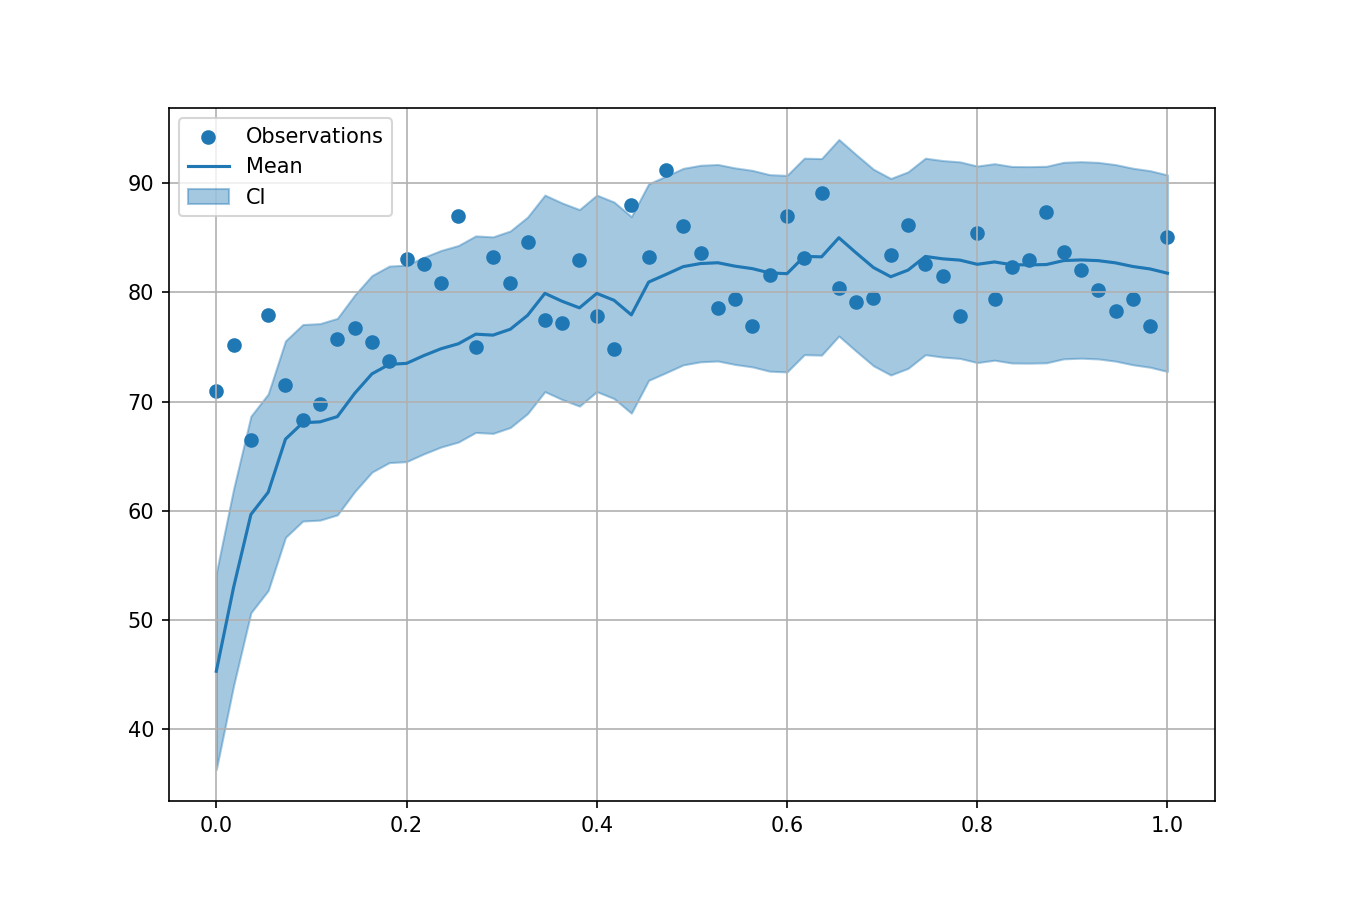

<IPython.core.display.Javascript object>


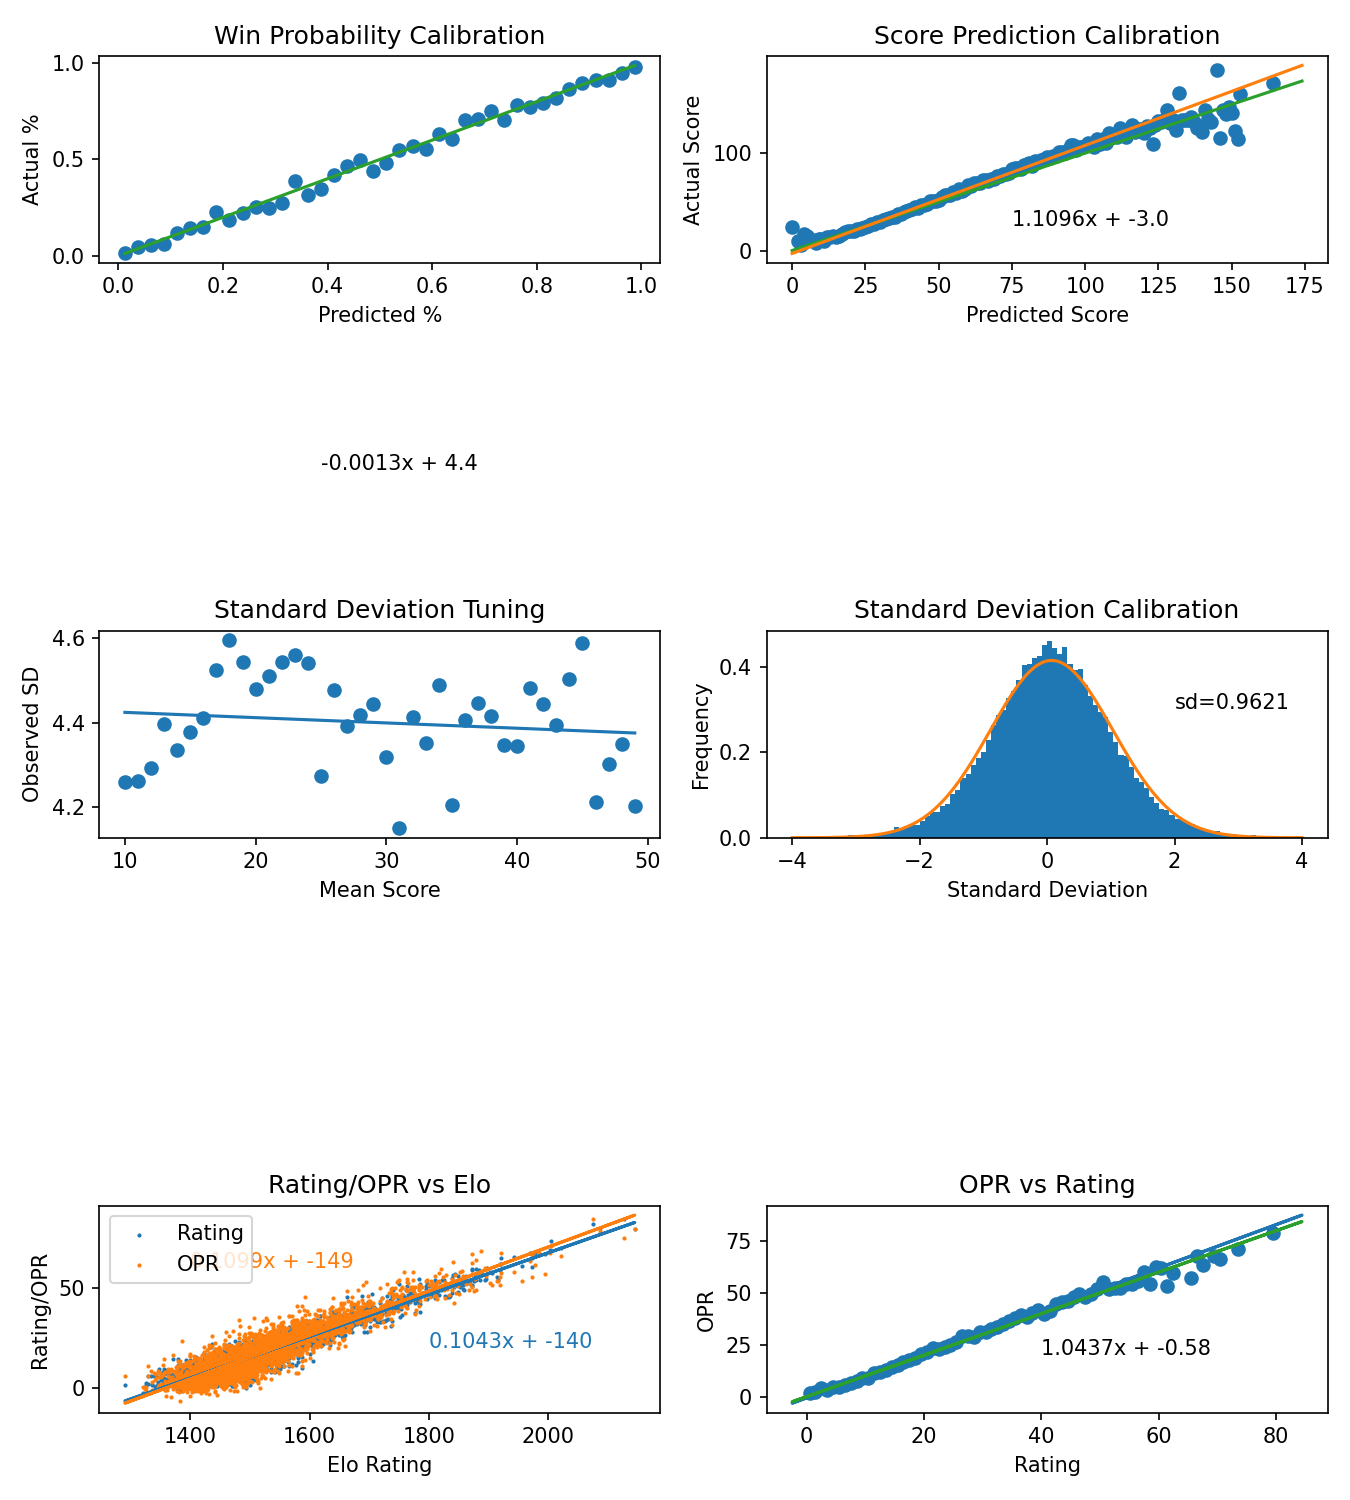

In [544]:
model.summary(teams=[254])
model.plot_calibration()

TODO: 
1. similar to calibration graphs, make one for top teams and some sample figures
2. Create models for Elo style model, split by auto/teleop/endgame

In [530]:
elos, oprs = {}, {}
for _, t in team_years_df[(team_years_df.year == 2022)].iterrows():
    elos[t.team] = t.elo_end
    oprs[t.team] = t.opr

x, y, y2 = [], [], []
for team in model.ratings:
    if model.ratings[team].end_mean() == 0:
        continue
    x.append(elos[team])
    y.append(model.ratings[team].end_mean())
    y2.append(oprs[team])
    
x, y, y2 = np.array(x), np.array(y), np.array(y2)

<IPython.core.display.Javascript object>


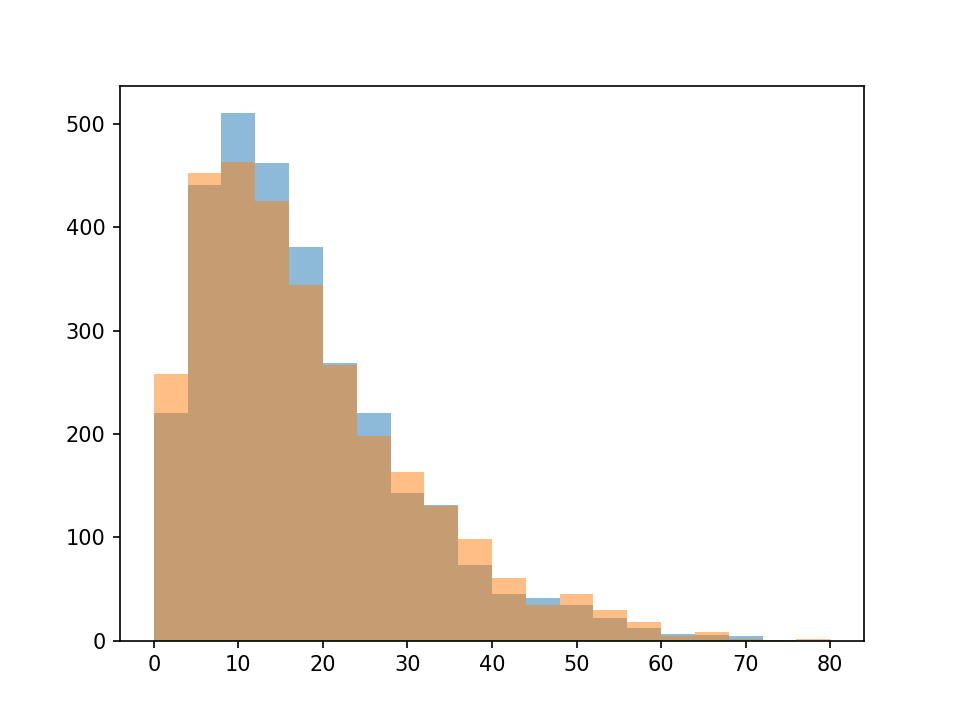

(array([258., 453., 463., 426., 344., 267., 198., 163., 130.,  99.,  61.,
         35.,  45.,  30.,  18.,   5.,   9.,   2.,   1.,   2.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40., 44., 48.,
        52., 56., 60., 64., 68., 72., 76., 80.]),
 <BarContainer object of 20 artists>)

In [535]:
fig, ax = plt.subplots()
ax.hist(y, bins=20, alpha=0.5, range=(0, 80))
ax.hist(y2, bins=20, alpha=0.5, range=(0, 80))

In [ ]:
data = []

n, prior_mean = 10, 13.8
simple_teams = defaultdict(lambda: SimpleTeam(n=n, prior_mean=prior_mean))
full_teams = defaultdict(lambda: FullTeam(n=1, prior_mean=prior_mean))
for _, t in team_years_df[(team_years_df.year == 2022)].iterrows():
    team, opr = t.team, (t.elo_start - 1361) / 9.25
    simple_teams[team] = SimpleTeam(n=n, prior_mean=opr)
    full_teams[team] = FullTeam(n=1, prior_mean=opr)

count, acc, mse = 0, 0, 0
event_count, event_acc, event_mse = 0, 0, 0
for _, match in event_matches_df.iterrows():
    red_teams = [int(x) for x in match.red.split(",")]
    blue_teams = [int(x) for x in match.blue.split(",")]
    
    model = full_teams
    red_means = [model[t].mean() for t in red_teams]
    red_sds = [model[t].sd() for t in red_teams]
    red_distrib = Normal(sum(red_means), sum(red_sds))
    blue_means = [model[t].mean() for t in blue_teams]
    blue_sds = [model[t].sd() for t in blue_teams]
    blue_distrib = Normal(sum(blue_means), sum(blue_sds))
    win_prob = Normal.sub(red_distrib, blue_distrib, 0).win_prob()
    
    data.append({
        "red_1": red_means[0],
        "red_2": red_means[1],
        "red_3": red_means[2],
        "red_pred": red_distrib.mu,
        "red_sd": red_distrib.sigma,
        "red_actual": match.red_no_fouls,
        "blue_1": blue_means[0],
        "blue_2": blue_means[1],
        "blue_3": blue_means[2],
        "blue_pred": blue_distrib.mu,
        "blue_sd": blue_distrib.sigma,
        "blue_actual": match.blue_no_fouls,
        "win_pred": win_prob,
        "win_actual": match.red_score > match.blue_score,
    })
    
    # win_prob = (win_prob + match.elo_win_prob) / 2
    
    mle_weight = 0.5
    for teams, actual in [(red_teams, match.red_no_fouls), (blue_teams, match.blue_no_fouls)]:
        means, sds = [simple_teams[t].mean() for t in teams], [simple_teams[t].sd() for t in teams]
        pred, variance = sum(means), sum([sd ** 2 for sd in sds])
        for team, mean, sd in zip(teams, means, sds):
            contrib1 = mean + 1 / 3 * (actual - pred)
            contrib2 = mean + sd ** 2 / variance * (actual - pred)
            simple_teams[team].add((1 - mle_weight) * contrib1 + mle_weight * contrib2)
            
    contribs = defaultdict(list)
    for teams, get_mean, get_sd, actual in [
        (red_teams, lambda t: t.auto.mean(), lambda t: t.auto.sd(), match.red_auto),
        (red_teams, lambda t: t.teleop.mean(), lambda t: t.teleop.sd(), match.red_teleop),
        (red_teams, lambda t: t.endgame.mean(), lambda t: t.endgame.sd(), match.red_endgame),
        (blue_teams, lambda t: t.auto.mean(), lambda t: t.auto.sd(), match.blue_auto),
        (blue_teams, lambda t: t.teleop.mean(), lambda t: t.teleop.sd(), match.blue_teleop),
        (blue_teams, lambda t: t.endgame.mean(), lambda t: t.endgame.sd(), match.blue_endgame),
    ]:
        means, sds = [get_mean(full_teams[t]) for t in teams], [get_sd(full_teams[t]) for t in teams]
        pred, variance = sum(means), sum([sd ** 2 for sd in sds])
        for team, mean, sd in zip(teams, means, sds):
            contrib1 = mean + 1 / 3 * (actual - pred)
            contrib2 = mean + sd ** 2 / variance * (actual - pred)
            contribs[team].append((1 - mle_weight) * contrib1 + mle_weight * contrib2)
            
    for t in contribs:
        full_teams[t].add(*contribs[t])
        
    if not match.playoff:
        count += 1
        acc += (win_prob > 0.5 and match.red_score > match.blue_score) or (win_prob < 0.5 and match.red_score < match.blue_score)
        mse += (1 - win_prob) ** 2 if match.red_score > match.blue_score else win_prob ** 2  
    
    if match.event in ["2022carv", "2022gal", "2022hop", "2022new", "2022roe", "2022tur"] and not match.playoff:
        # print(match.key)
        # print(red_teams, blue_teams)
        # print(red_total_distrib, blue_total_distrib, win_prob)
        # print(match.red_score, match.blue_score)
        # print()
        event_count += 1
        event_acc += (win_prob > 0.5 and match.red_score > match.blue_score) or (win_prob < 0.5 and match.red_score < match.blue_score)
        event_mse += (1 - win_prob) ** 2 if match.red_score > match.blue_score else win_prob ** 2  
    
print(count, acc / count, mse / count)
print(event_count, event_acc / event_count, event_mse / event_count)

In [ ]:
# TODO:
# 1. separate by component
# 3. skill starting value